In [297]:
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

### 1. Carga de datos

In [298]:
def load_data(filepath):
    return pd.read_csv(filepath, parse_dates=['Date'])

### 2. Division y tratamiento de datos

In [299]:
def create_sequences(data, target, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps)])
        y.append(target[i + n_steps])
    return np.array(X), np.array(y)

In [300]:
def prepare_data(df, target_column, n_steps):
    features = df.drop(columns=[target_column, 'LMCADY_std_5d_log'])

    # agregar dia mes y dia de la semana
    # features['Month'] = df['Date'].dt.month
    # features['Day'] = df['Date'].dt.day
    # features['Weekday'] = df['Date'].dt.weekday

    features = features.drop(columns = ['Date'])

    target = df[target_column]

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    X, y = create_sequences(features_scaled, target, n_steps)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle = False)

    return X_train, X_test, y_train, y_test

### 3. Arquitectura y compilacion

In [301]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [302]:
def build_model(input_shape, md_prm: dict):
    model = Sequential([
        Conv1D(filters=md_prm['filters']*2, kernel_size=md_prm['kernel_size'], activation='relu', input_shape=input_shape),
        Conv1D(filters=md_prm['filters'], kernel_size=md_prm['kernel_size'], activation='relu'),
        MaxPooling1D(pool_size=md_prm['pool_size']),
        Dropout(md_prm['dropout']/2),
        Flatten(),
        Dense(md_prm['dense_units']*2, activation='relu'),
        Dense(md_prm['dense_units'], activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=[rmse])
    return model

### 4. Entrenamiento del modelo

In [303]:
def train_model(model, X_train, y_train, epochs, batch_size, verbose):
    early_stopping = EarlyStopping(
        monitor             ='val_rmse',
        patience            =20,
        verbose             =1,
        restore_best_weights=True
    )
    history = model.fit(
        X_train, y_train,
        epochs          =epochs,
        batch_size      =batch_size,
        verbose         =verbose,
        validation_split=0.1,
        callbacks       =[early_stopping]
    )
    return history

In [304]:
# y_train.std()

In [305]:
# history = train_model(model, X_train, y_train, epochs=100, batch_size=32,)

### 5. Evaluacion de resultado

In [306]:
def evaluate_model(model, X_test, y_test):
    loss = model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss}')

In [307]:
# evaluate_model(model, X_test, y_test)

In [308]:
def plot_history(history):
    # plotear loss de entrenamiento y validación
    figsize = (8,2)

    plt.figure(figsize=figsize)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    # otras metricas
    for key in history.history.keys():
        if key not in ['loss', 'val_loss', 'val_rmse']:
            plt.figure(figsize=figsize)
            plt.plot(history.history[key], label=f'Training {key}')
            plt.plot(history.history[f'val_{key}'], label=f'Validation {key}')
            plt.title(f'Model {key.capitalize()}')
            plt.ylabel(key.capitalize())
            plt.xlabel('Epoch')
            plt.legend()
            plt.grid(True)
            plt.show()

In [309]:
def plot_predictions(y_true, y_pred, title="Prediction vs Actual Data"):
    plt.figure(figsize=(12,2))
    plt.plot(y_true, label='Actual Values', marker='o', linestyle='-')
    plt.plot(y_pred, label='Predicted Values', marker='x', linestyle='--')
    
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [310]:
# df = load_data("./input/copper_log_returns_5d_final.csv")
# n_steps = 25
# target_column = 'LMCADY_acu_5d_log'
# X_train, X_test, y_train, y_test = prepare_data(df, target_column, n_steps)
# y_test.std()
# model = build_model(X_train.shape[1:])
# history = train_model(model, X_train, y_train, epochs=100, batch_size=16)
# evaluate_model(model, X_test, y_test)

In [311]:
# n_steps_options     = [25, 50, 100, 150, 200]
# batch_size_options  = [32, 64, 128, 256]
n_steps_options     = [10]
batch_size_options  = [16]
epochs_options      = [100]

filters_options     = [128]
kernel_size_options = [2]
pool_size_options   = [1]
dense_units_options = [50]
dense_activation_options = ['relu']
activation_options  = ['relu']
dropout_options     = [0.1]


model_params_combinations = list(itertools.product(
    filters_options, kernel_size_options, pool_size_options, dense_units_options,
    dense_activation_options, activation_options, dropout_options
))
target_column = 'LMCADY_acu_5d_log'

In [312]:
# number of iterations
n_iter = len(n_steps_options) * len(batch_size_options) * len(epochs_options) * len(model_params_combinations)
print(f'Total iterations: {n_iter}')

Total iterations: 1


In [313]:
def run_model_iterations():
    top_results = []

    i = 1
    for n_steps, batch_size, epochs, (filters, kernel_size, pool_size, dense_units, dense_activation, activation, dropout) in itertools.product(n_steps_options, batch_size_options, epochs_options, model_params_combinations):
        try:
            # Carga de datos
            df = load_data("./input/copper_log_returns_5d_final.csv")

            print(f"\n{i}) Testing with n_steps={n_steps}, batch_size={batch_size}, epochs={epochs}, filters={filters}")

            # Preparación de los datos
            X_train, X_test, y_train, y_test = prepare_data(df, 'LMCADY_acu_5d_log', n_steps)

            # print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

            # show a sample of X_train
            print(f"X_train[1]: {X_train[1]}")
            print("X_train[1] shape: ", X_train[1].shape)

            print("X_train[2]: ", X_train[2])
            print("X_train[2] shape: ", X_train[2].shape)

            # print("X_train",X_train)
            # print("X_train shape: ", X_train.shape)
            

            # Configuración de parámetros del modelo
            model_params = {
                'filters'           : filters,
                'kernel_size'       : kernel_size,
                'pool_size'         : pool_size,
                'dense_units'       : dense_units,
                'dense_activation'  : dense_activation,
                'activation'        : activation,
                'dropout'           : dropout
            }

            # Construcción y entrenamiento del modelo
            model   = build_model(X_train.shape[1:], model_params)

            history = train_model(model, X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

            # Evaluación del modelo
            y_pred  = model.predict(X_test)
            rmse_ob = sqrt(mean_squared_error(y_test, y_pred))
            std_dev = y_test.std()

            # Calcular la diferencia absoluta
            difference = rmse_ob - std_dev

            # Guardar y ordenar resultados basados en la diferencia absoluta
            result = {
                'difference': difference,
                'rmse'      : rmse_ob,
                'std_dev'   : std_dev,
                'params'    : model_params,
                'history'   : history,
                'batch_size': batch_size,
                'n_steps'   : n_steps,
                'predictions': y_pred,
                'actuals'   : y_test
            }
            top_results.append(result)
            top_results = sorted(top_results, key=lambda x: x['difference'])[:5]

            print(f"\n{i}) RMSE: {rmse_ob:.6f}, Std Dev: {std_dev:.6f}, Difference: {difference:.6f}")
            print(f"Tested with n_steps={n_steps}, batch_size={batch_size}, epochs={epochs}, filters={filters}")
            print(f"Model params: {model_params}")


        except Exception as e:
            print(f"An error occurred: {e}. Skipping this combination.")
        i += 1

    return top_results

In [314]:
top_3_results = run_model_iterations()


1) Testing with n_steps=10, batch_size=16, epochs=100, filters=128
X_train[1]: [[ 0.79831889  0.80040695 -1.03757587 -0.06904589  1.39983903  0.35865953
   1.36157729  0.74946327]
 [ 0.65370742  0.60462075 -1.02227619  1.86565812 -1.57814758  1.8614009
  -0.03207981  0.06255857]
 [-0.30878993 -0.29283708  1.22321939 -0.58718539 -0.26370638 -0.92710464
  -1.10227386 -1.05509046]
 [ 0.59240196  0.57473072 -1.43065956 -1.23632129  0.40135445 -1.51780979
   1.66911171  0.51858413]
 [ 0.66191337  0.68054726  0.14205016  1.60887117  1.36516469  1.49104895
  -0.2648936  -0.1231808 ]
 [-0.7032432  -0.73027242 -1.46014117 -0.02871827 -1.3862384   0.26120267
   0.49620596  0.22824425]
 [ 0.41628695  0.37328803  0.4929381  -0.14820204  0.35898175  0.0506217
  -0.08477418 -0.36823445]
 [ 0.67590171  0.64846524 -0.53682876  0.4674234  -0.04599269  0.68828483
  -0.87925645 -0.77052553]
 [ 0.38985439  0.34814812  0.2665992  -1.26573066  0.94268988 -1.13074091
  -0.1917841   0.03763021]
 [ 0.23917583


Top 1 Model
Best RMSE: 0.031223 vs. a std of 0.030667
Model parameters: {'filters': 128, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 50, 'dense_activation': 'relu', 'activation': 'relu', 'dropout': 0.1}
n_steps: 10, batch_size: 16


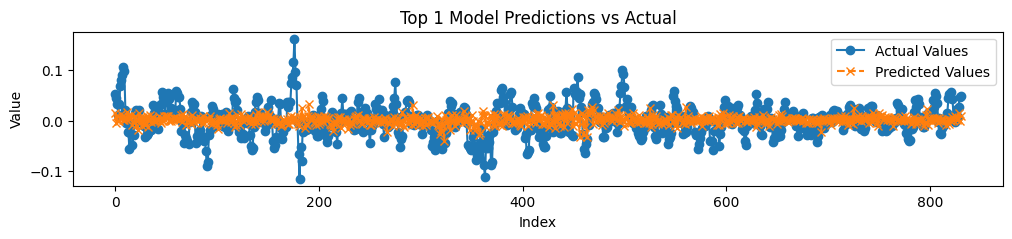

Predicted: 0.014300, Actual: 0.052256
Predicted: -0.005192, Actual: 0.045141
Predicted: 0.008959, Actual: 0.032116
Predicted: -0.000793, Actual: 0.012002
Predicted: -0.000809, Actual: 0.033687
Predicted: 0.004915, Actual: 0.068759
Predicted: 0.012545, Actual: 0.080933
Predicted: 0.007379, Actual: 0.091537
Predicted: 0.000749, Actual: 0.105688
Predicted: 0.002208, Actual: 0.098029


In [315]:
for i, result in enumerate(top_3_results, 1):
    rmse            = result['rmse']
    model_params    = result['params']
    history         = result['history']
    batch_size      = result['batch_size']
    n_steps         = result['n_steps']
    y_test          = result['actuals']
    y_pred          = result['predictions']

    print(f"\nTop {i} Model")
    print(f"Best RMSE: {rmse:.6f} vs. a std of {y_test.std():.6f}")
    print(f"Model parameters: {model_params}")
    print(f"n_steps: {n_steps}, batch_size: {batch_size}")

    # plot_history(history)

    plot_predictions(y_test, y_pred, title=f"Top {i} Model Predictions vs Actual")
    
    # print the values of predictions and actuals one next to the other(only the first 10)
    for pred, actual in zip(y_pred[:10], y_test[:10]):
        print(f"Predicted: {pred[0]:.6f}, Actual: {actual:.6f}")
    